## Аггрегация разметки датасета MathLogicQA
*Joint MathQA + MathLogicQA dataset after verification*

Аггрегация строится по следующей системе:

1. Сбор размеченных пулов с Толоки. Возможны варианты:
    - только общий пул нужно аггрегировать, тогда забирается только он
    - часть данных находится в контрольных заданиях и экзамене, тогда к основному пулу добавляются данные задания
2. Фильтрация разметчиков:
    - в общем пуле есть некоторое количество заранее размеченных заданий - контрольных
    - хорошим считается разметчик, который показывает `accuracy >= 0.5` на данных заданиях
    - формируется список "плохих" разметчиков
3. Аггрегация ответов разметчиков по заданиям:
    - форматирование в заданиях может отличаться от изначального из-за выгрузки с Толоки
    - учитываются только ответы "хороших" разметчиков
    - аггрегация по подготовленным пулам - создается массив карточек вида {key: value}, где key - кортеж из всех значимых элементов задания, value - список из кортежей вида (user_id, answer)
4. Голосование большинством по каждому заданию:
    - минимально необходимое большинство составляет 3 голоса, так как такое большинство валидно для перекрытия 5
    - по результату формируется датафрейм с заданиями и ответами
5. Подгрузка оригинальных данных с разметкой в виде таблицы с заданиями и ответами
6. Соединение таблиц:
    - очистка форматирования в таблице с ответами разметчиков и в таблице с правильными ответами
    - создание единых столбцов с полным заданием
    - соединение таблиц по данному столбцу
    - валидация размеров
7. Подсчет метрик

In [1]:
import pandas as pd
from collections import Counter

### Сбор данных разметки и фильтрация разметчиков

Датасет проходил разметку одним пулом из 1143 объектов, которые были получены путем фильтрации перевода оригинального сета на русский язык.

In [2]:
assignments = pd.read_csv('assignments_from_pool_41847389__20-10-2023.tsv', sep='\t')

In [3]:
assignments.shape

(8573, 19)

Разметчикам предлагалось на основании имеющейся текстовой задачи и вариантов ответа на нее ответить на вопрос, какой ответ правильный. 

Вход: 
- INPUT:problem (пример: `Сколько будет два плюс два`).
- INPUT:option1 (пример: `4`).
- INPUT:option2 (пример: `1`).
- INPUT:option3 (пример: `-4`).
- INPUT:option4 (пример: `0`).

Выход:
- OUTPUT:solution (одна из четырех букв на выбор: `A`, `B`, `C`, `D`).

В разметке были задачи, в которых предлагалось не 4, а 3 или 2 варианта ответа. Для них количество возможных букв в ответе, соответственно, сокращалось.

In [4]:
assignments.head(1)

,INPUT:option1,INPUT:option2,INPUT:option3,INPUT:option4,INPUT:problem,OUTPUT:solution,GOLDEN:solution,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:submitted,ASSIGNMENT:accepted,ASSIGNMENT:reward
0,неправда,невозможно определить,нет правильного ответа,правда,2 умножить на r минус t равно 1. 2 умножить на...,D,D,NaN,NaN,https://platform.toloka.ai/task/41847389/00027...,00027e8a5d--6531445f90b596667cdeab6c,00027e8a5d--65314dbab28c1e25e8d0234c,00027e8a5d--65314dbab28c1e25e8d0234a,1b2fbe75c141718717281a939bdb0e49,APPROVED,2023-10-19T15:39:38.951,2023-10-19T15:40:52.386,2023-10-19T15:40:52.386,0.042


Фильтруем толокеров, которые дали меньше половины корректных ответов на контрольных заданиях.

In [5]:
from collections import defaultdict

users_dict = defaultdict(lambda: defaultdict(int))

for idx, row in assignments.iterrows():
    problem = row[4]

    out = row[5]
    
    gold = row[6]

    user = row[13]

    if str(user) != "nan" and str(gold) != "nan":
        if out == gold:
            users_dict[user]["good"] += 1
        else:
            users_dict[user]["bad"] += 1

print("Users total: ", len(users_dict))
bad_users = []
for key, value in users_dict.items():
    percentage_good = value["good"]/(value["good"] + value["bad"])
    if percentage_good < 0.5:
        bad_users.append(key)

print("Bad users:", len(bad_users))

Users total:  232
Bad users: 25


25 из 232 разметчиков на контрольных заданиях показали слишком плохое качество, чтобы учитывать их ответы для расчета метрики.

Теперь нужно оставить только основной пул. Контрольные задания генерировались на основе задач из основного пула, но с существенными изменениями условий и ответов, потому их нужно убрать. На контрольных заданиях есть `GOLDEN:solution`. Также отсеиваем возможные баги Толоки, когда в строке может не быть задания - `INPUT:problem` содержит NaN.

In [6]:
assignments_no_control = assignments[assignments['GOLDEN:solution'].isnull()]
assignments_no_control_no_null = assignments_no_control[assignments_no_control['INPUT:problem'].notnull()]

### Сбор ответов разметчиков и голосование

Собираем ответы голосования большинством для каждого задания.

In [7]:
from collections import defaultdict

text_dict = defaultdict(list)

for prob, user, out in zip(
    assignments_no_control_no_null["INPUT:problem"], assignments_no_control_no_null["ASSIGNMENT:worker_id"], 
    assignments_no_control_no_null["OUTPUT:solution"]
    ):
    if user not in bad_users:
        text_dict[prob].append([
                user,
                {"out": out}
        ])

print(len(text_dict))

1143


In [8]:
keys = list(text_dict.keys())
Counter([len(text_dict[keys[i]]) for i in range(len(keys))])

Counter({5: 1080, 4: 60, 3: 3})

Есть 63 задания с перекрытием меньше 5. Правила применяем к ним те же, что и для перекрытия 5: большинство в 3 голоса определяет результат голосования, иначе задание не учитывается.

In [9]:
preds_full = {}
for i in range(len(keys)):
    ans = text_dict[keys[i]]
    lst = [ans[j][1]['out'] for j in range(len(ans))]
    cnt = Counter(lst)
    most = Counter([ans[j][1]['out'] for j in range(len(ans))]).most_common(1)[0][1]
    if most >= 3:
        res = Counter([ans[j][1]['out'] for j in range(len(ans))]).most_common(1)[0][0]
        preds_full[keys[i]] = res

In [10]:
len(preds_full)

1130

В 13 заданиях согласованность достигнута не была - их выкидываем.

In [11]:
preds_full_df = pd.concat([pd.DataFrame(preds_full.keys(), columns=['prob']), pd.DataFrame(preds_full.values(), columns=['lb'])], axis=1)

### Сопоставление разметки и ground truth

Забираем задания из датасета с правильными метками.

In [12]:
res_df = pd.read_csv('full_dataset.csv')
res_df = res_df.rename({'text': 'prob', 'outputs': 'lb'}, axis=1)

In [13]:
res_df.head(1)

,prob,option_a,option_b,option_c,option_d,lb,task,part
0,"Разность -3, 4 и 5 равна 6, умноженному на n. ...",3,-2,-3,2,B,math,train


После скачивания с Толоки в текстах рушится форматирование, потому нельзя просто сделать join двух табличек. Нужно убрать все "лишнее" форматирование сразу из двух табличек, чтобы остались только тексты, пунктуация и пробелы.

In [14]:
def format_text(text):
    text = (text.strip().replace('\n', ' ').replace('\t', ' ')
            .replace('\r', ' ').replace('  ', ' ').replace('  ', ' ')
            .replace('  ', ' '))
    return text

res_df['prob'] = res_df['prob'].apply(format_text)
preds_full_df['prob'] = preds_full_df['prob'].apply(format_text)

Делаем left join, чтобы соединить голосование и правильные метки для одних и тех же заданий.

In [15]:
new = res_df.merge(preds_full_df, on='prob', how='left')

In [16]:
new_valid = new[new['lb_y'].notna()].copy()
len(new_valid)

1130

In [18]:
new_valid.head(1)

,prob,option_a,option_b,option_c,option_d,lb_x,task,part,lb_y
681,"Если сложить 38, умноженное на m и 33, умножен...",71,-10,10,11,C,math,test,C


### Подсчет метрики

Если в правом столбце меток осталось 259 непустых строк, значит, форматирование было подчищено корректно и ничего не потерялось.

In [19]:
(new_valid['lb_x'] == new_valid['lb_y']).mean()

0.9946902654867257

`Accuracy = 0.995`

### Анализ ошибок

In [20]:
from scipy import stats
import numpy as np

После голосования есть всего 6 ошибок - никакой информации из этих 6 ошибок извлечь нельзя, так как ошибок слишком мало, чтобы какой-либо вывод был взвешенным. Посмотрим на изначальный пул ответов разметчиков на каждое задание.

In [22]:
pool = pd.read_csv('assignments_from_pool_41847389__20-10-2023.tsv', sep='\t')
pool.head(1)

,INPUT:option1,INPUT:option2,INPUT:option3,INPUT:option4,INPUT:problem,OUTPUT:solution,GOLDEN:solution,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:submitted,ASSIGNMENT:accepted,ASSIGNMENT:reward
0,неправда,невозможно определить,нет правильного ответа,правда,2 умножить на r минус t равно 1. 2 умножить на...,D,D,NaN,NaN,https://platform.toloka.ai/task/41847389/00027...,00027e8a5d--6531445f90b596667cdeab6c,00027e8a5d--65314dbab28c1e25e8d0234c,00027e8a5d--65314dbab28c1e25e8d0234a,1b2fbe75c141718717281a939bdb0e49,APPROVED,2023-10-19T15:39:38.951,2023-10-19T15:40:52.386,2023-10-19T15:40:52.386,0.042


Будем считать рассогласованность по энтропии Шеннона.

In [23]:
def entropy(arr):
    arr = np.asarray(arr).reshape(-1,)
    cats = np.unique(arr)
    probs = np.array([(arr == val).mean() for val in cats])
    if (probs == 1).sum():
        return 0
    return -(probs * np.log2(probs)).sum()

Убираем контрольные задания, так как они не нужны.

In [25]:
pool = pool[pool['GOLDEN:solution'].isna()].reset_index(drop=True)
pool = pool.iloc[:, [0, 1, 2, 3, 4, 5, 13]]

In [26]:
pool = pool.rename({
    'INPUT:option1': 'op1',
    'INPUT:option2': 'op2',
    'INPUT:option3': 'op3',
    'INPUT:option4': 'op4',
    'INPUT:problem': 'prob',
    'OUTPUT:solution': 'sol',
    'ASSIGNMENT:worker_id': 'user'
}, axis=1)

Join с правильными ответами.

In [28]:
pool['prob'] = pool['prob'].apply(format_text)

In [29]:
pool = pool.merge(res_df.drop(['option_a', 'option_b', 'option_c', 'option_d', 'part'], axis=1), on='prob', how='left')

In [30]:
pool['cor'] = pool['sol'] == pool['lb']
pool['cor'].mean(), pool.shape[0] - pool['cor'].sum()

(0.92668416447944, 419)

Вот 419 ошибок отдельных толокеров - это то количество, из которого можно попробовать извлечь информацию.

In [31]:
new = (pd.DataFrame({'prob': pool.prob.unique()})\
 .merge(pool.groupby('prob')['sol'].agg(list), on='prob'))\
    .merge(pool.groupby('prob').agg(mean_correct = pd.NamedAgg(column='cor', aggfunc='mean')), on='prob')

Попробуем все же посчитать рассогласованность через энтропии Шеннона на списках ответов, чтобы быть уверенным, что информация оттуда бесполезна.

In [32]:
new['entropy'] = new['sol'].apply(entropy)

Соединяем задачу с датасетом: MathQA или MathLogicQA, присвоив число, соответствующее датасету: 1 или 2.

In [33]:
prob2ds = {k:v for k, v in zip(pool.drop_duplicates(subset='prob')['prob'], pool.drop_duplicates(subset='prob')['task'])}

In [36]:
new['ds'] = new['prob'].apply(lambda x: prob2ds[x])
new['ds_code'] = new['ds'].map({'math': 1, 'logimath': 2})

In [37]:
new.head(3)

,prob,sol,mean_correct,entropy,ds,ds_code
0,"Если сложить 11 и 12, то получится 23, умножен...","[D, D, D, D, D]",1.0,0.0,math,1
1,"Если к -35, умноженному на s, прибавить 9, то ...","[C, C, C, C, C]",1.0,0.0,math,1
2,"Если из -r вычесть 5, то получится -g. Если из...","[B, B, B, B, B]",1.0,0.0,math,1


In [38]:
def corrs(arr1, arr2):
    return {
        "Pearson corr": stats.pearsonr(arr1, arr2)[0],
        "Spearman corr": stats.spearmanr(arr1, arr2)[0],
        "Kendall corr": stats.kendalltau(arr1, arr2)[0],
    }

Посмотрим, есть ли какие-нибудь корреляции в полученном датасете.

In [42]:
print("Корреляция с энтропией")
pd.DataFrame({
    "Средняя корректность ответов размечтиков на задание": corrs(new['mean_correct'], new['entropy']),
    "Номер датасета (MathQA или MathLogicQA)": corrs(new['entropy'], new['ds_code']),
    "Длина задания": corrs(new['entropy'], new['prob'].apply(len)),
}).round(3).transpose()

Корреляция с энтропией


,Pearson corr,Spearman corr,Kendall corr
Средняя корректность ответов размечтиков на задание,-0.949,-0.999,-0.994
Номер датасета (MathQA или MathLogicQA),-0.100,-0.102,-0.099
Длина задания,0.161,0.190,0.153


Чем больше в среднем разметчики верно ответили на задание, тем меньше энтропия, ведь неправильных ответов меньше. Длина задания почти не влияет на энтропию.

In [44]:
print("Корреляция со средней корректностью ответов на каждое задание")
pd.DataFrame({
    "Номер датасета (MathQA или MathLogicQA)": corrs(new['mean_correct'], new['ds_code']),
    "Длина задания":corrs(new['mean_correct'], new['prob'].apply(len)),
}).round(3).transpose()

Корреляция со средней корректностью ответов на каждое задание


,Pearson corr,Spearman corr,Kendall corr
Номер датасета (MathQA или MathLogicQA),0.104,0.103,0.100
Длина задания,-0.155,-0.190,-0.153


А вот с датасетом никакой связи нет. Получается, ошибки не особо зависят от конкретного датасета. Длина задачи снова совсем немного влияет на точность и согласованность.

Теперь посмотрим на отдельные ответы разметчиков.

In [45]:
pool['cor'] = pool['cor'].astype(int)
pool['ds_code'] = pool['task'].map({'math': 1, 'logimath': 2})

In [47]:
print("Корреляция с корректностью ответа на задание")
pd.DataFrame({
    "Номер датасета (MathQA или MathLogicQA)": corrs(pool['cor'], pool['ds_code']),
    "Длина задания": corrs(pool['cor'], pool['prob'].apply(len)),
}).round(3).transpose()

Корреляция с корректностью ответа на задание


,Pearson corr,Spearman corr,Kendall corr
Номер датасета (MathQA или MathLogicQA),0.055,0.055,0.055
Длина задания,-0.083,-0.100,-0.082


Снова никакой связи между правильными ответами (или ошибками) и датасетом или длиной задачи. Может варианты ответа влияют? Например, если ответ не числовой, то ошбки могут расти.

In [48]:
pool['lit_ops'] = pool['op1'].apply(lambda x: x[0].isalpha()).astype(int)

In [51]:
print("Корреляция с корректностью ответа на задание")
pd.DataFrame({
    "Буквенный ответ": corrs(pool['cor'], pool['lit_ops']),
}).round(3).transpose()

Корреляция с корректностью ответа на задание


,Kendall corr,Pearson corr,Spearman corr
Буквенный ответ,-0.11,-0.11,-0.11


Нечисловые варианты ответа почти никак не влияют на результат. Может быть переменные в задаче влияют на результат?

Достанем наименования неизвестных для уравнений.

In [52]:
def get_symbs(obj):
    return list(set(list(filter(lambda y: not y.isdigit(), list(filter(lambda z: len(z) == 1, list(map(lambda x: x[:-1].strip() if (x.endswith(',') or x.endswith('.')) else x, obj.split()))))))))

In [53]:
def filt_symbs(obj):
    lst = get_symbs(obj)
    lst = list(filter(lambda x: ord(x) < 130, lst))
    return list(filter(lambda x: x.isalpha(), lst))

In [54]:
pool['vars'] = pool['prob'].apply(filt_symbs)

In [55]:
print("Корреляция с корректностью ответа на задание")
pd.DataFrame({
    "Количество переменных": corrs(pool['cor'], pool['vars'].apply(len)),
}).round(3).transpose()

Корреляция с корректностью ответа на задание


,Kendall corr,Pearson corr,Spearman corr
Количество переменных,-0.137,-0.143,-0.143


Количество неизвестных очень слабо влияет.

In [56]:
new['vars'] = new['prob'].apply(filt_symbs)

In [57]:
print("Корреляция с количеством неизвестных в условии задания")
pd.DataFrame({
    "Средняя корректность ответов разметчиков на задание": corrs(new['mean_correct'], new['vars'].apply(len)),
    "Энтропия ответов разметчиков на задание": corrs(new['entropy'], new['vars'].apply(len)),
}).round(3).transpose()

Корреляция с количеством неизвестных в условии задания


,Pearson corr,Spearman corr,Kendall corr
Средняя корректность ответов разметчиков на задание,-0.267,-0.266,-0.246
Энтропия ответов разметчиков на задание,0.270,0.266,0.246


А вот на среднюю точность очень даже влияет - хоть какой-то результат...

А что, если есть конкретные наименования переменных, которые влияют на результат. Достанем названия неизвестных.

In [59]:
all_vars = sorted(list(set(list(map(lambda x: x.lower(), set(new['vars'].sum()))))))

Посчитаем корреляции сердней корректности и энтропии ответов разметчиков на задание с наличием конкретной переменной в задании.

In [61]:
var_cor = {}
var_ent = {}
for i in range(len(all_vars)):
    var_name = all_vars[i]
    mask = new['vars'].apply(lambda x: var_name in x)
    corr1 = stats.pearsonr(new['mean_correct'], mask)[0]
    corr2 = stats.pearsonr(new['entropy'], mask)[0]
    var_cor[var_name] = corr1
    var_ent[var_name] = corr2

In [62]:
import matplotlib.pyplot as plt

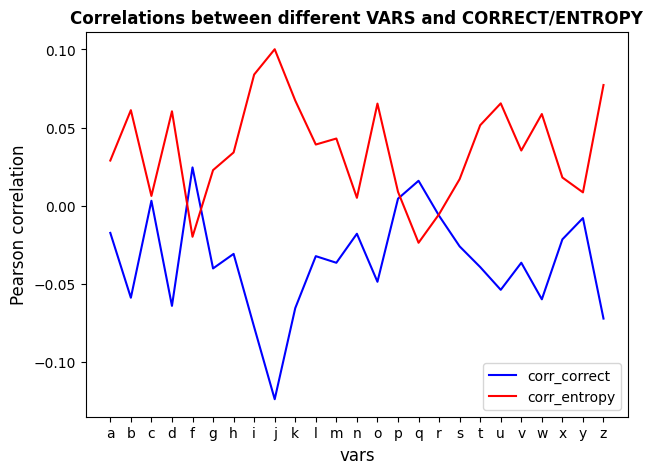

In [63]:
plt.figure(figsize=(7, 5))
plt.title('Correlations between different VARS and CORRECT/ENTROPY', weight='bold')
plt.plot(var_cor.values(), c='b', label='corr_correct')
plt.plot(var_ent.values(), c='r', label='corr_entropy')
plt.xlabel('vars', size=12)
plt.ylabel('Pearson correlation', size=12)
plt.legend(loc='lower right')
plt.xticks(ticks=range(len(all_vars)), labels=list(var_cor.keys()))
plt.show()

В абсолютных значениях связи особой нет. Но в относительных значениях видно, что переменная с именем `j` странным образом связана с ошибками. Но такая связь крайне сомнительна, так как сложность зависит от самой задачи в первую очередь, плюс задач с разными переменными не одинаковое количество, а также есть много задач с двумя неизвестными.

Возможно, для отдельных ответов разметчиков свзяь будет более явной и значимой.

In [67]:
var_cor = {}
for i in range(len(all_vars)):
    var_name = all_vars[i]
    mask = pool['vars'].apply(lambda x: var_name in x)
    corr1 = stats.pearsonr(pool['cor'], mask)[0]
    var_cor[var_name] = corr1

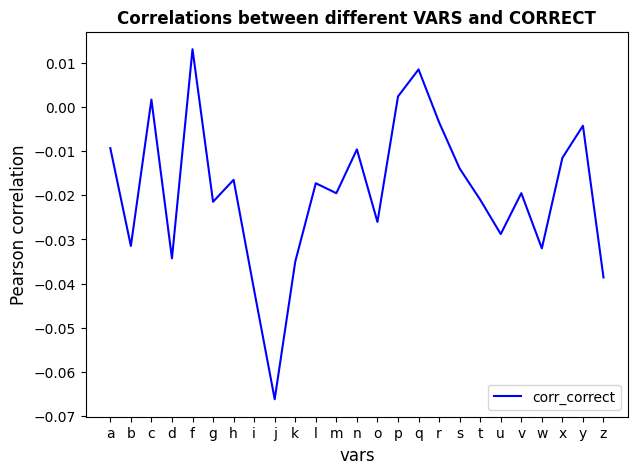

In [68]:
plt.figure(figsize=(7, 5))
plt.title('Correlations between different VARS and CORRECT', weight='bold')
plt.plot(var_cor.values(), c='b', label='corr_correct')
plt.xlabel('vars', size=12)
plt.ylabel('Pearson correlation', size=12)
plt.legend(loc='lower right')
plt.xticks(ticks=range(len(all_vars)), labels=list(var_cor.keys()))
plt.show()

Нет, график очень похож на предыдущий. Однако значения корреляций слишком малы, чтобы можно было делать вывод о наличии зависимости.